<img src="../../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Python Bootcamp and Summer Workshop on the Dynamic Brain</h1> 
<h3 align="center">Wednesday, August 23, 2017</h3> 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import random

from modelingsdk.builder.networks import SynNetwork

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Modeling biophysically detailed cells with NEURON</h1>
In this tutorial, we will create a network of 8 cells. Four of these cells will be biophysically detailed and four will be Leaky-Intergrate-and-Fire (LIF) models. 
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/Full_figure.png" alt=Drawing style="width: 500px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Build recurrent network</h1>
For building the 8 node network, we will save the nodes (neurons) and edges (connections) separately.  
</div>

In [2]:
# Output file names
directory_name = 'network/recurrent_network/'

# Create direcoty if it doesn't exist
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
We will explore the directory structure of how files are being saved later. Just know for now that we will be creating files ans saving them in a directory called "network".
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Building Nodes</h2>
In this section we will be creating the nodes only. They are not receiving input nor connected to each other yet. The schematic below illustrates where we will be.
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/Neurons_created.png" alt=Drawing style="width: 350px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
In addition to saving nodes and edges separately, the nodes themselves are described by two files, one containing all information that are unique to nodes and one containing all information that are unique to models. We differentiate nodes and models because there can be a handful of models but thousands of nodes. With this, everything that is unique for nodes, such as position, goes in the nodes file. Parameters that are repeated (such as morphology, electrohphysiology parameters) can be stored and referenced in the model files (which we call node_types).
</div>

In [3]:
# Nodes files
nodes_file = directory_name + 'nodes.csv'              # Contains information about every node
node_models_file = directory_name + 'node_types.csv'   # Contains information about models

In [4]:
### Number of cell models desired
N_Scnn1a = 2
N_PV1 = 2
N_LIF_exc = 2
N_LIF_inh = 2

In [5]:
### Define all the cell models in a dictionary (note dictionaries within a dictionary)
biophysical_models = {
    
    # Cell type. Here we are using a pyrmaidal models from an Scnn1a Cre-line. Other
    # models exist in the components directory if you would like to explore them.
    'Scnn1a': { 
        # Number of nodes (neurons) we would like to create
        'N': N_Scnn1a,               
        # This is a unique number the user defines (or one is generated randomly). This
        # is required as it is the key that links nodes.csv with node_types.csv as will
        # be seen below.
        'node_type_id': '10001', 
        # Key to indicate if the neuron is excitatory or inhibitory
        'ei': 'e', 
        # Key to store the population name of the model. One can have many
        # models (node_type_id) that belong to a single populations
        'pop_name': 'Scnn1a', 
        # Attribute to indicate this model is biophysical (instead of LIF for example)
        'level_of_detail': 'biophysical',
        # The morpholgy file for this model (NEURON template). This is stored in the components
        # directory if you would like to explore it more (plus other models). 
        'morphology_file': 'Scnn1a-Tg3-Cre_Ai14_IVSCC_-177300.01.02.01_473845048_m.swc',
        # The electrophysiology parameters file for this model. Again, this is stored
        # in the components directory with other models if you wish to check them out.
        'params_file': '472363762_fit.json',
        # Fixed for every model but needs to be defined. This is the angle of the 
        # morphology reconstruction relative to the pia.
        'rotation_angle_zaxis': -3.646878266,
        # Flag that tells the simulator what type of cell this is and how to read and
        # interpret the given files. This is created to allow users to define cell
        # models in any way they want as long as they final function returns an object
        # that can be interpreted by NEURON (called a hoc-object)
        'set_params_function': 'Biophys1'
    },
    
    # Below are the same attributes but with different values for the PV cell we will be
    # modeling in out network.
    'PV1': {
        'N': N_PV1,
        'node_type_id': '10002',  
        'ei': 'i', 
        'pop_name': 'PV1',
        'level_of_detail': 'biophysical',
        'morphology_file': 'Pvalb-IRES-Cre_Ai14_IVSCC_-176847.04.02.01_470522102_m.swc',
        'params_file': '472912177_fit.json',
        'rotation_angle_zaxis': -2.539551891,
        'set_params_function': 'Biophys1'
    }
}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Example function for illustrative purposes</h1>
The below is simply a function that will return random coorindates for nodes. The purpose of this functions is to show you how to use the API to create your own custom functions. It will be used in the subsequent cell.
</div>

In [6]:
def generate_random_positions(N):
    '''
    Generate N random positions.
    N: number of positions to generate
    '''

    x = np.random.random(N)     # x-axis location
    y = np.random.random(N)     # y-axis location
    z = np.random.random(N)     # z-axis location

    positions = np.column_stack((x, y, z))

    return positions

In [7]:
### Create nodes set for each biophysical population

# A network object is created of SynNetwork class. This will store all the 
# information about the nodes and connections between nodes. The object has
# multiple methods (functions) that we will be using below to build the network
# nodes first and connections second.
net = SynNetwork('FridayHarborBiophysics')

# We will loop through every model and create nodes. Note the main function
# below is net.add_nodes()
for model in biophysical_models:
    
    # Read the first biophysical model parameters dictionary
    params = biophysical_models[model]

    # Calculate positions for every cell (x, y, z). The called function was created
    # above. It doesn't do anything special other than create positions for nodes
    # from a random number generator. But one can write more sophisticated algorithms
    # for positions if they choose.
    positions = generate_random_positions(params['N'])

    # Adds node populations giving it all the input paramters one would like.
    net.add_nodes(params['N'], position='points', position_params={'location': positions},
                  array_params={'rotation_angle_yaxis': np.random.uniform(0.0, 2*np.pi, params['N'])},
                  node_type_id=params['node_type_id'],
                  ei = params['ei'],
                  pop_name=params['pop_name'],
                  level_of_detail=params['level_of_detail'],
                  params_file=params['params_file'],
                  morphology_file=params.get('morphology_file', 'NA'),
                  rotation_angle_zaxis=params.get('rotation_angle_zaxis', 'NA'),
                  set_params_function=params['set_params_function'])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Exercise 1: </h3>
<p>Create the LIF cells  
<p>Add a population of excitatory and inhibitory LIF neurons. 
<p>First create a dictionary as do the biophysical example
<p>To do this,  select a unique node_type_id and pop_name.  
<p>Some names are unique to NEURON and must be named accordingly for LIFs:  
<p>'level_of_detail': 'intfire',  
<p>'params_file': 'IntFire1_exc_1.json',  
<p>'set_params_function': 'IntFire1'  
  
<p>Note that you do not need to add a morphology file or rotation angle for the z-axis here.
</div>

In [8]:
### Define all the cell models in a dictionary.
LIF_models = {
    'LIF_exc': {
        'N': N_LIF_exc, 
        'node_type_id': '90001', 
        'ei': 'e', 
        'pop_name': 'LIF_exc',
        'level_of_detail': 'intfire',
        'params_file': 'IntFire1_exc_1.json',
        'set_params_function': 'IntFire1'
    },
    'LIF_inh': {
        'N': N_LIF_inh,
        'node_type_id': '90002',  
        'ei': 'i', 
        'pop_name': 'LIF_inh',
        'level_of_detail': 'intfire',
        'params_file': 'IntFire1_inh_1.json',
        'set_params_function': 'IntFire1'
    }
}

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Exercise 2:</h3>
Loop through the dictionary as done before to add the cells. Note that can use same code as used for biophysical and NA will be placed for the non-required inputs automatically.  
<p>In practice one will use one for-loop and dictionary for all node-types.
</div>

In [9]:
### Create a node set for each biophysical population
for model in LIF_models:
    params = LIF_models[model]

    # Precacluate positions, rotation angles for each N neurons in the population
    positions = generate_random_positions(params['N'])

    # Adds node populations
    net.add_nodes(params['N'], 
                  position='points', 
                  position_params={'location': positions},
                  array_params={'rotation_angle_yaxis': np.random.uniform(0.0, 2*np.pi, params['N'])},
                  node_type_id=params['node_type_id'],
                  ei = params['ei'],
                  pop_name=params['pop_name'],
                  level_of_detail=params['level_of_detail'],
                  params_file=params['params_file'],
                  morphology_file=params.get('morphology_file', 'NA'),
                  rotation_angle_zaxis=params.get('rotation_angle_zaxis', 'NA'),
                  set_params_function=params['set_params_function'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Saving nodes in csv file</h2>
To save the nodes, it is important to highlight the difference between nodes and models.
<p> Nodes refers to the specific neuron instantiations that are created and will have specific properties such as position coordinates. Each neuron still corresponds to a specific model though.  
<p> Models describe the properties of sets of neurons that are common. In our case, these include the electrophysiological parameters and the morphology. This is, as mentioned above, because we use the same model to create multiple cells of those models.  
<p>As such, in the save functions below, we save the neurons (cells) and the models (types). This create two .csv files which you should examine. Note that both have node_type_id as a common column which will tell the simulator that the node selected corresponds to a specific node type which it can reference from the node_types table.
</div>

In [10]:
# Save the cells in the nodes.csv file. Here we define the columns a user would like to
# save in this file. Note that node_type_id is required. Also note that node_id will be 
# created automatically. The positions label is reserved and input in a specific manner.
net.save_cells(filename=nodes_file,
               columns=['node_id', 'node_type_id', 'position', 
                        'rotation_angle_yaxis', 'pop_name', 'ei'],
               position_labels=['x_soma', 'y_soma', 'z_soma'])

# Save the node_types.csv file. Again the columns to be saved in this file are set by
# the user. Again, node_type_id is needed here and it is the bridge between the two files
# being saved here.
net.save_types(filename=node_models_file, 
               columns=['node_type_id', 'params_file', 'level_of_detail', 'morphology_file',
                        'rotation_angle_zaxis', 'set_params_function'])

In [11]:
# Show the nodes file
nodes_DF = pd.DataFrame.from_csv(nodes_file, sep = ' ')
nodes_DF 

,node_type_id,x_soma,y_soma,z_soma,rotation_angle_yaxis,pop_name,ei
node_id,,,,,,,
0,10002,0.108415,0.305189,0.366250,5.074337,PV1,i
1,10002,0.298124,0.295988,0.233395,1.499839,PV1,i
2,10001,0.436857,0.100581,0.662882,1.424295,Scnn1a,e
3,10001,0.157626,0.109129,0.813339,4.824271,Scnn1a,e
4,90002,0.146513,0.222657,0.282946,2.813464,LIF_inh,i
5,90002,0.897435,0.029918,0.693494,1.833889,LIF_inh,i
6,90001,0.839450,0.487175,0.016398,0.992701,LIF_exc,e
7,90001,0.637185,0.443640,0.423824,0.568466,LIF_exc,e


In [12]:
# Show the node_types file. Note the common column is node_type_id
node_types_DF = pd.DataFrame.from_csv(node_models_file, sep = ' ')
node_types_DF

,params_file,level_of_detail,morphology_file,rotation_angle_zaxis,set_params_function
node_type_id,,,,,
10002,472912177_fit.json,biophysical,Pvalb-IRES-Cre_Ai14_IVSCC_-176847.04.02.01_470...,-2.539552,Biophys1
10001,472363762_fit.json,biophysical,Scnn1a-Tg3-Cre_Ai14_IVSCC_-177300.01.02.01_473...,-3.646878,Biophys1
90002,IntFire1_inh_1.json,intfire,NaN,NaN,IntFire1
90001,IntFire1_exc_1.json,intfire,NaN,NaN,IntFire1


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Setting connections (edges)</h2>
Now we will create edges between all nodes (8*7 = 56 edges since no self-connections) as shown in the example figure below.
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/Recurrent_connected.png" alt=Drawing style="width: 500px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
Similar to nodes, the edge files are saved into two files, one that describes unique edges between nodes (e.g. node 315 connects to node 938) and the other that describes the properties of different edges.
</div>

In [13]:
# Edges files
edge_types_file = directory_name + 'edge_types.csv'   # Contains info. about every edge type
edges_file = directory_name + 'edges.h5'             # Contains info. about every edge created

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Example function for illustrative purposes</h1>
The below is simply a function that will determine whether or not two nodes are connected to one another. If they are connected the number of synapses forming the connection is also determined. In this function, d_max is a cut-off that determines if the neurons are close enough to connect or not connect. Below, you will see that we choose a very large d_max such that all neurons are connected to one another. The purpose of this functions is to show you how to use the API to create your own custom functions. It will be used in the subsequent cells.
</div>

In [14]:
def distance_connection_handler(source, target, d_max, nsyn_min, nsyn_max):
    '''
    Connect cells that are less than d_max apart
    with a random number of synapses in the 
    interval [nsyn_min, nsyn_max)
    '''
    
    sid = source['node_id']    # Get source id
    tid = target['node_id']    # Get target id
    
    # Avoid self-connections.
    if (sid == tid):
        return None

    # first calculate euclidean distance between cells
    separation = np.sqrt(   np.sum( (np.array(source['position']) - np.array(target['position'])) **2 )  )

    # drop the connection if nodes too far apart
    if separation >= d_max:
        return

    # Add the number of synapses for every connection.
    tmp_nsyn = random.randint(nsyn_min, nsyn_max)
    return tmp_nsyn

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Generating I-to-I connections</h3>
</div>

In [15]:
# The cparameters dictionary is the connection parameters dictionary which will be 
# used between connected nodes. In this API, this is how arguments/variables are given to
# the connection function (defined earlier and will be used below). 
# Here the function that will use these parameters was defined at the start of the notebook
# and was called distance_connection_handler().

cparameters = {'d_max': 160.0,    # Maximum separation between nodes where connection allowed 
               'nsyn_min': 3,     # If connection exist, minimum number of synapses
               'nsyn_max': 7}     # If connection exist, maximum number of synapses

In [16]:
# Here we will give a connection rule we want to impose on the network. Note that
# we only give the rules (and associated functions) and the networks. The API
# will then loop and determine the connections that satify the rules.

net.connect(
    # Connection rule states A: Everytime the source node (pre-synaptic neuron) is inhibitory
    source={'ei': 'i'}, 
    # Connection rule states B: Everytime the target node (post-synamtic neuron) is
    # inhibitory and of biophysical detail. One can change this of course to another
    # rule that depends on pop_name or node_mode_id for instance.
    target={'ei': 'i', 'level_of_detail': 'biophysical'},
    # Function that will determine the rules of connectivity. This was defined before
    # and required 5 arguments. However, note that the source node and target
    # node will be automatically be set as arguments to the function and hence only
    # need 3 arguments. This function only determined if node X is connected to node Y.
    # The parameters of the connections are defined below (edge_parameters)
    connector=distance_connection_handler,
    # The remaining arguments needed by distance_connection_handler that we defined above.
    connector_params=cparameters,
    # The parameters for when a connection exists
            edge_params={
                # weight_max defines the strength of the connection. It depends on the 
                # target cell mechanism. Here, this will be interpreted as the peak
                # conductance measure in uS.
                'weight_max': 0.03, 
                # When the target is a biophysical neuron, the location of the connections 
                # (synapses) along the neuron must be defined.
                'distance_range': [0.0, 1e+20],
                # Further, when the target is a biophysical neuron, the regions of the 
                # neuron being targeted need to be defined.
                'target_sections': ['somatic', 'basal'], 
                # Axonal delay between when pre-synaptic node fires and post-synaptic
                # target responds. The unit is milliseconds
                'delay': 2.0,
                # File that contains the parameters for the synaptic weight which you can
                # explore in the components directory. The naming convention below indicates
                # that the synapse dynamics are GABA for an Inh to Inh node.
                'params_file': 'GABA_InhToInh.json', 
                # params_file only has parameter values, but the mechanism (profile) of
                # synaptic dynamics are defined in NEURON. Here we use exp2syn where you
                # can find more info here:
                # https://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/mech.html#Exp2Syn
                'set_params_function': 'exp2syn'})

In [17]:
# When the target is a LIF neuron. Note here that distance_range and target_sections are
# not needed. Also, due to how NEURON handles LIF neurons, the synaptic profile has an
# instantaneous increase (after the synaptic delay) and no params_function is neeeded.
net.connect(source={'ei': 'i'}, 
            target={'ei': 'i', 'level_of_detail': 'intfire'},
            connector=distance_connection_handler,
            connector_params=cparameters,
            edge_params={'weight_max': 0.3, 
                         'delay': 2.0,
                         'params_file': 'instanteneousInh.json'})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Generating I-to-E connections</h3>
</div>

In [18]:
# As above, need to give different rules for when the target is a biophysical neuron.
net.connect(source={'ei': 'i'}, 
            target={'ei': 'e', 'level_of_detail': 'biophysical'},
            connector=distance_connection_handler,
            connector_params=cparameters,
            edge_params={'weight_max': 0.3, 
                         'distance_range': [0.0, 50.0],
                         'target_sections': ['somatic', 'basal', 'apical'], 
                         'delay': 2.0,
                         'params_file': 'GABA_InhToExc.json',
                         'set_params_function': 'exp2syn'})

In [19]:
# As above, need to give different rules for when the target is a LIF neuron.
net.connect(source={'ei': 'i'}, 
            target={'ei': 'e', 'level_of_detail': 'intfire'},
            connector=distance_connection_handler,
            connector_params=cparameters,
            edge_params={'weight_max': 0.4,
                         'delay': 2.0,
                         'params_file': 'instanteneousInh.json'})

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Excercise 3:</h3>
<p> Complete the remaining connections: E-to-I, and E-to-E  
<h4> Hints:  </h4>
<p>-You can use the same cparameters values  
<p>-Available params_files are: GABA_InhToInh.json, GABA_InhToExc.json, AMPA_ExcToInh.json, AMPA_ExcToExc.json, instanteneousInh.json, instanteneousExc.json  
<p>-Inhibitory neurons only have 'somatic' and 'basal' compartments. Excitatory neurons also have 'apical'.  
<p>-When the target neuron is inhibitory and biophysical, suggested distance range is [0.0, 1e+20] that targets somatic and basal compartments.  
<p>-When the target neuron is exctiatory, suggested distance range is [30.0, 150.0] that targets basal and apical compartments.  
<p>-Suggested weights, but you can experiment,: E-to-I biphysical = 0.05, E-to-I LIF =0.2, E-to-E biphysical = 0.05, E-to-E LIF = 0.05
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Generating E-to-I connections</h3>
</div>

In [20]:
net.connect(source={'ei': 'e'}, target={'pop_name': 'PV1'},
            connector=distance_connection_handler,
            connector_params=cparameters,
            edge_params={'weight_max': 0.05, 'distance_range': [0.0, 1e+20],
                         'target_sections': ['somatic', 'basal'], 'delay': 2.0,
                         'params_file': 'AMPA_ExcToInh.json', 'set_params_function': 'exp2syn'})

net.connect(source={'ei': 'e'}, target={'pop_name': 'LIF_inh'},
            connector=distance_connection_handler,
            connector_params=cparameters,
            edge_params={'weight_max': 0.2, 'delay': 2.0,
                         'params_file': 'instanteneousExc.json'})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Generating E-to-E connections</h3>
</div>

In [21]:
net.connect(source={'ei': 'e'}, target={'pop_name': 'Scnn1a'},
            connector=distance_connection_handler,
            connector_params=cparameters,
            edge_params={'weight_max': 0.05, 'distance_range': [30.0, 150.0], 
                         'target_sections': ['basal', 'apical'], 'delay': 2.0,
                         'params_file': 'AMPA_ExcToExc.json', 'set_params_function': 'exp2syn'})

net.connect(source={'ei': 'e'}, target={'pop_name': 'LIF_exc'},
            connector=distance_connection_handler,
            connector_params=cparameters,
            edge_params={'weight_max': 0.05, 'delay': 2.0, 
                         'params_file': 'instanteneousExc.json'})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Building network...</h2>
</div>

In [22]:
# This will actually build the network and determine which nodes are connected to which. 
# Until now, only the rules were given and stored.
net.build()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Saving edges</h2>
</div>

In [23]:
# Save the edge_types file which we will view below. As when saving the nodes, there are
# optional columns to save based on user applications. Here we give all the columns that
# are required for our case.
net.save_edge_types(edge_types_file, 
                    opt_columns=['weight_max', 'distance_range','target_sections', 
                                                  'delay', 'params_file', 'set_params_function'])

# The edges are saved in a HDF5 format. If you would like to see how they are saved, you
# will need to install special software (HDFviewer or Vitables are good options.)
net.save_edges(filename=edges_file)

save_edges
> building tables with 8 nodes and 56 edges
> saving tables to network/recurrent_network/edges.h5


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
Below we only show the edge_types file as the description of the edges is in a .h5 file format and can't be show here. If you have any questions about it, please ask us and we are happy to give you more detailed about how it is saved. If you would like to see how they are saved, you
will need to install special software (HDFviewer or Vitables are good options.)
</div>

In [24]:
edge_types_DF = pd.DataFrame.from_csv(edge_types_file, sep = ' ')
edge_types_DF

,target_query,source_query,weight_max,distance_range,target_sections,delay,params_file,set_params_function
edge_type_id,,,,,,,,
0,level_of_detail=='biophysical'&ei=='i',ei=='i',0.03,"[0.0, 1e+20]","['somatic', 'basal']",2.0,GABA_InhToInh.json,exp2syn
1,level_of_detail=='intfire'&ei=='i',ei=='i',0.30,NaN,NaN,2.0,instanteneousInh.json,NaN
2,level_of_detail=='biophysical'&ei=='e',ei=='i',0.30,"[0.0, 50.0]","['somatic', 'basal', 'apical']",2.0,GABA_InhToExc.json,exp2syn
3,level_of_detail=='intfire'&ei=='e',ei=='i',0.40,NaN,NaN,2.0,instanteneousInh.json,NaN
4,pop_name=='PV1',ei=='e',0.05,"[0.0, 1e+20]","['somatic', 'basal']",2.0,AMPA_ExcToInh.json,exp2syn
5,pop_name=='LIF_inh',ei=='e',0.20,NaN,NaN,2.0,instanteneousExc.json,NaN
6,pop_name=='Scnn1a',ei=='e',0.05,"[30.0, 150.0]","['basal', 'apical']",2.0,AMPA_ExcToExc.json,exp2syn
7,pop_name=='LIF_exc',ei=='e',0.05,NaN,NaN,2.0,instanteneousExc.json,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Build input driving sources</h1>
In a parallel manner to before, we will now create the input network and connect it to the excitatory cells we have already made. 
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/External_input_connected.png" alt=Drawing style="width: 500px;">

In [25]:
# Will save the output files in a parallel manner to what we did before.

# Output file names
directory_name = 'network/source_input/'

if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    
input_nodes_file        = directory_name + 'input_nodes.csv'
input_models_file       = directory_name + 'input_node_types.csv'
input_edge_types_file   = directory_name + 'input_edge_types.csv'
input_edges_file        = directory_name + 'input_edges.h5'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Builing input sources</h2>
</div>

In [26]:
# Create input dictionary. Will use "filters" in this example and the dictionary 
# has already been created for you below. In the following you will create the nodes
# and save them as was done for the recurrent network. Note that we are making 25 
# external nodes. In reality, we are just creating nodes that will spike and not filtering 
# any stimulus in particular.

filter_models = \
        {
        'inputFilter': {'N': 25, 'node_type_id': '1001', 'ei': 'e', 'pop_name': 'input_filter', 'level_of_detail': 'filter'}
        }

In [27]:
# Create a network object
inputNetwork = SynNetwork("inputNetwork")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Exercise 4:</h3>
Create and an external network with the dictionary parameters given above. Note that here less parameters are needed than before.
</div>

In [28]:
# Add each cell type to the network
for model, params in filter_models.items():
    inputNetwork.add_nodes(params['N'],
                  node_type_id = params['node_type_id'],
                  pop_name=params['pop_name'],
                  level_of_detail = params['level_of_detail'],
                  ei=params['ei'])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Exercise 5:</h3>
<p> Save the input network as done before.   
<p>- For the save_cells fuction, use: columns=['node_id', 'node_type_id', 'ei', 'pop_name']  
<p>- For the save_types function, use: columns=['node_type_id', 'level_of_detail']
</div>

In [29]:
# write cells and cell_models to csv file
inputNetwork.save_cells(filename=input_nodes_file,
               columns=['node_id', 'node_type_id', 'ei', 'pop_name'])
inputNetwork.save_types(filename=input_models_file, columns=['node_type_id', 'level_of_detail'])

In [30]:
# Print the first 5 external nodes
input_nodes_DF = pd.DataFrame.from_csv(input_nodes_file, sep = ' ')
input_nodes_DF[1:5]

,node_type_id,ei,pop_name
node_id,,,
1,1001,e,input_filter
2,1001,e,input_filter
3,1001,e,input_filter
4,1001,e,input_filter


In [31]:
# Print the external node types
input_node_types_DF = pd.DataFrame.from_csv(input_models_file, sep = ' ')
input_node_types_DF

,level_of_detail
node_type_id,
1001,filter


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Connect input sources to recurrent network</h2>
Although it is already in memory, we will load the recurrent network again under a different name to illustrate how one can load older networks.
</div>

In [32]:
# If want to load saved recurrent network from before. 
# This is done to show how to load a network.
net_saved = SynNetwork.load(name='original_nodes', nodes=nodes_file,
                              positions=['x_soma', 'y_soma', 'z_soma'])

In [33]:
# Defining a function that will select source sources to connect to the network.
# In this example, all source cells will connect but this gives you an idea of
# how custom functions can be created to select subsets of input sources nodes.
# Also we here introduce a new concept for connecting nodes. Here the function
# receives all sources and a single target. An algorithm can determine which
# sources connect to the given target. The function will return a list of length
# equal to the number of sources. The elements in the list can be either N_syn
# everytime there is a connection or None when there is no connection.
def select_source_cells(sources, target, N_syn):
    '''
    Note here that sources are given (not source). So the iterations occur through every target 
    with all sources as potential inputs. Faster that before and better if will have common rules.
    '''

    target_id = target['id']
    source_ids = [s['id'] for s in sources]

    nsyns_ret = [N_syn]*len(source_ids)
    return nsyns_ret

In [34]:
# Similar to as was done for the recurrent network.  
cparams = {'N_syn': 10}

In [35]:
# Connect the external population to the biphysical exctitaory nodes (Scnn1a).
# This is the same format as before, but note that this time we give an input
# to the connect function called "iterator". Previously, when we did not use this
# the default "one_to_one" was used. When in the default "one_to_one" case, the 
# connector function iterates through every source and target one by one. When
# the iterator is "all_to_one", the connector function will expect all sources
# to be received together for every target. Other options are "one_to_all". The
# final option "all_to_all" is still not available.
net_saved.connect(source=inputNetwork.nodes(), target={'pop_name': 'Scnn1a'},
            iterator='all_to_one',
            connector=select_source_cells,
            connector_params=cparams,
            edge_params={'weight_max': 0.0007, 
                         'distance_range': [0.0, 150.0],
                         'target_sections': ['basal', 'apical'], 
                         'delay': 2.0,
                         'params_file': 'AMPA_ExcToExc.json',
                         'set_params_function': 'exp2syn'})

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Excercise 6:</h3>
Below we connect the souce network to the LIF excitatory neurons. Change the pop_name to the pop_name you defined previously for LIF excitatory nodes.
</div>

In [36]:
# Connect the external population to the LIF exctitaory nodes 
# USE "pop_name" YOU DEFINED BEFORE
net_saved.connect(source=inputNetwork.nodes(), target={'pop_name': 'LIF_exc'},
            iterator='all_to_one',
            connector=select_source_cells,
            connector_params=cparams,
            edge_params={'weight_max': 0.07, 
                         'delay': 2.0,
                         'params_file': 'instanteneousExc.json'})

In [37]:
# If want to connect input to inhibitory
# net_saved.connect(source=inputNetwork.nodes(), target={'pop_name': 'PV1'},
#             iterator='all_to_one',
#             connector=select_source_cells,
#             connector_params=cparams,
#             edge_params={'weight_max': 0.002, 'distance_range': [0.0, 1.0e+20],
#                          'target_sections': ['somatic', 'basal'], 'delay': 2.0,
#                          'params_file': 'AMPA_ExcToInh.json',
#                          'set_params_function': 'exp2syn'})

# net_saved.connect(source=inputNetwork.nodes(), target={'pop_name': 'LIF_inh'},
#             iterator='all_to_one',
#             connector=select_source_cells,
#             connector_params=cparams,
#             edge_params={'weight_max': 0.01, 'delay': 2.0,
#                          'params_file': 'instanteneousExc.json'})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Build the network and save the edges</h3>
The same functions are before.
</div>

In [38]:
net_saved.build()

In [39]:
net_saved.save_edge_types(input_edge_types_file, opt_columns=['weight_max', 'distance_range',
                                                  'target_sections', 'delay', 'params_file', 'set_params_function'])

net_saved.save_edges(filename=input_edges_file)

save_edges
> building tables with 8 nodes and 100 edges
> saving tables to network/source_input/input_edges.h5


In [40]:
input_edge_types_DF = pd.DataFrame.from_csv(input_edge_types_file, sep = ' ')
input_edge_types_DF

,target_query,source_query,weight_max,distance_range,target_sections,delay,params_file,set_params_function
edge_type_id,,,,,,,,
8,pop_name=='Scnn1a',*,0.0007,"[0.0, 150.0]","['basal', 'apical']",2.0,AMPA_ExcToExc.json,exp2syn
9,pop_name=='LIF_exc',*,0.0700,NaN,NaN,2.0,instanteneousExc.json,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Explore the directory structure</h3>
At this point you may want to explore the directory structure that has been created to see how and where the files were saved. 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Create spike times of input cells</h2>
In addition to creating connectivity between the external population and the recurrent population, we need to define what input the external population is giving. This will be in the form of spike trains as illustrated below and is the last step for creating a network and running it.
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/Full_figure.png" alt=Drawing style="width: 500px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Spike train</h3>
Below is code that will create spike-trains for every neuron drawn from a Poisson process. A firing rate is set for all neurons and the final output file is saved in an nwb format (neurodata without borders) which we will not be discussing in this tutorial but feel free to ask a TA for more information.
</div>

In [41]:
import modelingsdk.simulator.utils.nwb as nwb

# Based on algorithm from Dayan and Abbott and the following website:
# https://praneethnamburi.wordpress.com/2015/02/05/simulating-neural-spike-trains/

firingRate = 0.5           # Hz
dt = 1./1000               # 1 millisecond time bins
totalTime = 10000          # Milliseconds
time = np.arange(0, totalTime, dt*1000)

input_spike_file_name = directory_name + 'poisson_input_spk_train.nwb'
# Write nwb file:
f = nwb.create_blank_file(input_spike_file_name, force=True)

numNeurons = filter_models['inputFilter']['N']
numTrials  = 2
for gid in range(numNeurons):
    for trial_number in range(numTrials):
        PoissonTrain = np.random.rand(1, int(totalTime)) < (firingRate * dt)
        spkTimes = time[PoissonTrain[0]]
        nwb.SpikeTrain(spkTimes, unit='millisecond').add_to_processing(f, 'trial_%s' % trial_number)
f.close()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Config file</h1>
With so many files created (nodes, edges, spiking) and given (morpholgies, e-phys parameters), everything needs to be integrated together which is done in a config file. This file has already been created and below we are printing it. Feel free to also look at the config file directly as it will look better than the print function below.
</div>

In [42]:
import json
import pprint

with open('config.json') as config:
    config_file = json.load(config)

pprint.pprint(config_file)


{u'components': {u'bio_morphology_dir': u'$MODELS_DIR/biophysical/morphology',
                 u'bio_params_dir': u'$MODELS_DIR/biophysical/electrophysiology',
                 u'hoc_template_dir': u'$MODELS_DIR/hoc_templates',
                 u'lif_params_dir': u'$MODELS_DIR/intfire',
                 u'mechanisms_dir': u'$MODELS_DIR/mechanisms',
                 u'synapses_dir': u'$MODELS_DIR/synaptic_models'},
 u'conditions': {u'celsius': 34.0, u'v_init': -80},
 u'external': {u'filter': {u'edge_types': u'$NETWORK_DIR/source_input/input_edge_types.csv',
                           u'edges': u'$NETWORK_DIR/source_input/input_edges.h5',
                           u'func_labels': [],
                           u'node_types': u'$NETWORK_DIR/source_input/input_node_types.csv',
                           u'nodes': u'$NETWORK_DIR/source_input/input_nodes.csv',
                           u'spike_trains': u'$NETWORK_DIR/source_input/poisson_input_spk_train.nwb',
                           u'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Run function</h1>
Below is the run fuction that will read the config file and run our simulation on NEURON. Feel free to examine it if you are interested. Otherwise, the next cell simply calls the function and gives in the config file.
</div>

In [43]:
import os
import sys
import modelingsdk.simulator.bionet.config as config
from modelingsdk.simulator.bionet import io, nrn
from modelingsdk.simulator.bionet.network import Network
from modelingsdk.simulator.bionet.graph import Graph
from modelingsdk.simulator.bionet.simulation import Simulation
import set_weights
import set_cell_params
import set_syn_params


def run_sim(config_file):
    conf = config.from_json(config_file) # Build a configuration paths
    io.setup_output_dir(conf)            # Create output directory tree structure

    nrn.load_neuron_modules(conf)        # Load NMODL mechanisms,hoc templates
    nrn.load_py_modules(set_cell_params=set_cell_params, # Load custom Python modules
                        set_weights=set_weights,
                        set_syn_params=set_syn_params)

    graph = Graph(conf)                 # Load network description
    net = Network(conf, graph=graph)    # Create a network based on graph structure
    net.make_cells()                    # Instantiate internal cells
    net.make_stims()                    # Instantiate external cells (inputs)

    net.set_connections()               # Connect cells

    sim = Simulation(conf, network = net) # Create an instance of a simulation

    sim.set_recordings()                # Set up recordings
    sim.run()                           # Run the simulation

In [44]:
run_sim('config.json')

Overwriting the output directory /home/forrestc/SWDB_2017/DynamicBrain/Modeling/biophysical_notebook/sim_results_001:
Created a log file -- on 2017/08/18 at 18:19:24
Output directory: /home/forrestc/SWDB_2017/DynamicBrain/Modeling/biophysical_notebook/sim_results_001 -- t_wall: 3.010493 s
Config file: /home/forrestc/SWDB_2017/DynamicBrain/Modeling/biophysical_notebook/config.json -- t_wall: 3.010899 s
Number of ranks: 1 -- t_wall: 3.066511 s
Number of nodes: 8 -- t_wall: 3.06964 s
Set up node properties -- t_wall: 3.071846 s
Setting up network... -- t_wall: 3.082225 s
Created morphologies -- t_wall: 3.34472 s
Set segment properties -- t_wall: 3.350046 s
Set segment coordinates -- t_wall: 3.500441 s
Cells are instantiated -- t_wall: 3.500943 s
Loaded nodes for filter -- t_wall: 3.505863 s
Initializing all connections. Will flush all if exist -- t_wall: 3.522263 s
Setting up connections... -- t_wall: 3.522717 s
Setting connections from  filter -- t_wall: 3.522931 s
    set 1000 synapses 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Basic analysis of output</h1>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Plot raster plot</h3>
First we load the spikes outputs of our simulation.
The output file contains two columns -- spike time (in millseconds) and node_id. Each time a cell spikes, a new row with the node_id and the spike time is added to the file.
</div>

In [45]:
# Load the spikes
spks = np.loadtxt(config_file['manifest']['$OUTPUT_DIR'][10:] + config_file['output']['spikes_ascii'][11:])

# Print the first 10 spikes
# spks[:, 0] is the spike-time
# spks[:, 1] is the neuron id that fired at that time
print(spks[1:10, :])

[[ 1409.      3. ]
 [ 1408.      4. ]
 [ 1408.      5. ]
 [ 1406.      6. ]
 [ 1406.      7. ]
 [ 1725.9     2. ]
 [ 1815.9     2. ]
 [ 1725.      3. ]
 [ 1814.9     3. ]]


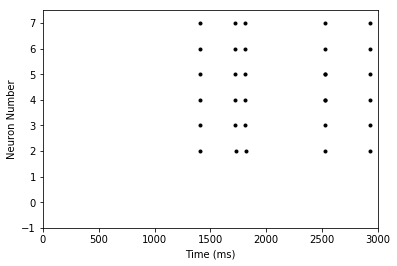

In [46]:
# Basic raster plot
plt.plot(spks[:, 0], spks[:, 1], '.k')
plt.xlim(0, config_file['run']['tstop'])
plt.ylim(-1, 7.5)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Number')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Excercise 7:</h3>
Zoom into speicific time window of raster to see interactions better.
<p>Hint: change plt.xlim()
</div>

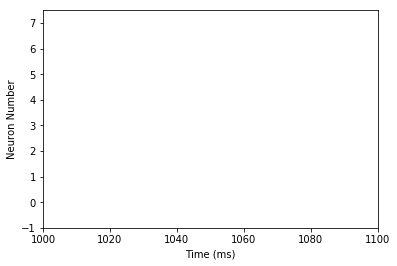

In [47]:
plt.plot(spks[:,0], spks[:, 1], '.k')
plt.xlim(1000, 1100)
plt.ylim(-1, 7.5)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Number')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Plot membrane trace of node</h3>
Membrane traces are also stored and saved in a .h5 file format. Below we show how to access, load, and plot the membrane traces.
</div>

In [48]:
# Get the file name of node #2
node = 2
h5_output_file = config_file['manifest']['$OUTPUT_DIR'][10:] + \
                    config_file['output']['cell_vars_dir'][11:] + '/' + str(node) + '.h5' 
print(h5_output_file)

sim_results_001/cellvars/2.h5


In [49]:
# Load the file for a node and see all the recorded variables
import h5py
f = h5py.File(h5_output_file, 'r')
for key in f:
    print('Variables recorded: ',key)

Variables recorded:  cai
Variables recorded:  spikes
Variables recorded:  v


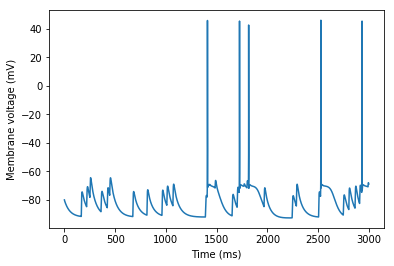

In [50]:
# Select the membrane voltage variable and plot it
mem_vol = np.array(f.get('v'))
time = np.arange(0, config_file['run']['tstop'], config_file['run']['dt'])
plt.plot(time, mem_vol)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Excercise 8:</h3>
Plot the membrane potential of all biophysically detailed neurons in a subplot. Look at the difference in subthreshold activity between the excitatory and inhibitory cells (recalled only excitatory get input from the external population).
</div>

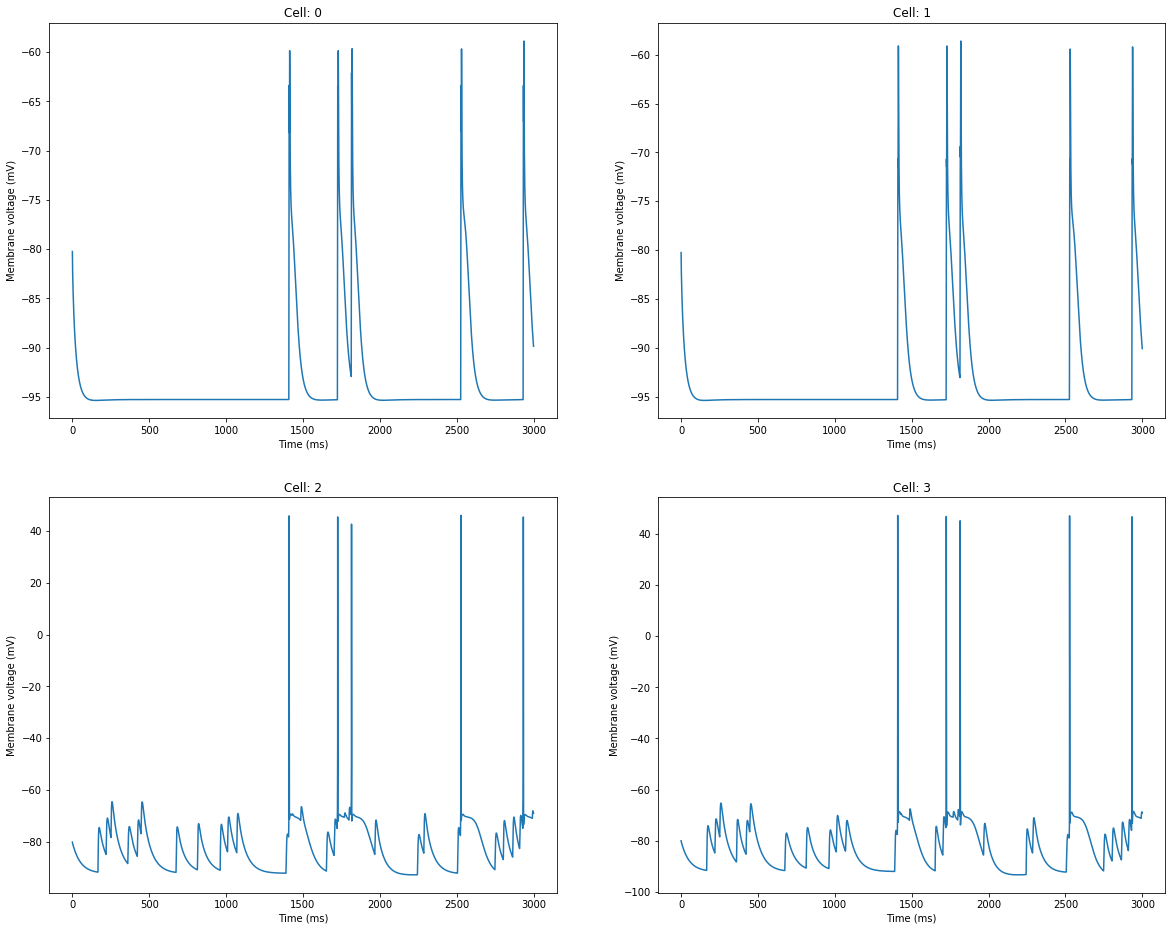

In [51]:
nodes = [0, 1, 2, 3]
plt.figure(figsize = (20, 16))
plt.subplot(2, 2, 1)
for i, node in enumerate(nodes):
    h5_output_file = config_file['manifest']['$OUTPUT_DIR'][10:] + \
                        config_file['output']['cell_vars_dir'][11:] + '/' + str(node) + '.h5' 
    f = h5py.File(h5_output_file, 'r')

    
    plt.subplot(2, 2, i + 1)
    mem_vol = np.array(f.get('v'))
    time = np.arange(0, config_file['run']['tstop'], config_file['run']['dt'])
    plt.plot(time, mem_vol)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    plt.title('Cell: ' + str(node))


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h2>Homework exercises:</h2>
<p>1. Explore the directory structure created from this notebook that represents the network  
<p>2. Explore the directory components that was created for you and contains more cell types  
<p>3. Download and HDF5 viewer and explore the .h5 files created.  
<p>4. Simulate one biophysical neuron receiving a large number of balanced excitatory and inhibitory inputs. Choose a cell model other than Scnn1a or PV1. Explore the effects of changing the target locations (somatic, basal, apical) of the excitatory and inhibitory inputs.  
<p>5. We have another directory >>pointnet_notebook that shows how to use the same files and circuit created here to run a point neural network simulation. The simulator engine is NEST (http://www.nest-simulator.org/) and some changes had to be made to the config file and network description (documented in the notebook) based on NEST nomenclature requirements. Feel free to explore and play around with the notebook and NEST.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Project Ideas:</h2>
<p>1. Compare visual responses between the Layer 4 model and Brain Observatory.  

<p>2. Find an optimal kernel for converting spikes from the Layer 4 model to Ca2+ signal, to maximize the agreeement with the Brain Observatory data.  

<p>3. Build a small-scale point-neuron network model receiving visual inputs; run simulations to explore visual responses.  

<p>4. Build a small-scale point-neuron network; explore the effect of different connectivity rules on the spatio-temporal dynamics.  

<p>5. Build a population-statistics DiPDE model analogous to the biophysical Layer 4 model.  Investigate whether similar dynamics can be obtained.  

<p>6. Build a population-statistics DiPDE model of all cortical layers.  Explore cortical dynamics in simulations.  
</div>

In [52]:
# commands to compile neuron modules safe to ignore if on AWS
# %%bash
# CURR_DIR=$(pwd)
# rm -rf components/mechanisms/x86_64/
# cd components/mechanisms/
# source ~/.bashrc
# nrnivmodl modfiles
# cd $CURR_DIR
